
# Phase 3: Spatiotemporal Integration

## Section 1 – Data Preparation
This section includes the libraries, data loading, and preprocessing steps.


In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import ccf
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# --- 1. INTEREST DATA PREPARATION FUNCTION ---
def prepare_interest_data(file_path="crypto_interest_global.csv"):
    """Cleans and prepares the geographic interest data."""
    df = pd.read_csv(file_path)
    df = df.rename(columns={'Week': 'Date', 'Interest': 'Interest', 'Crypto': 'Crypto', 'Country': 'Country'})

    # Clean and convert 'Interest' to numeric
    df['Interest'] = (
        df['Interest']
        .astype(str)
        .str.replace(">", "", regex=False)
        .str.replace("<", "", regex=False)
        .str.replace(",", ".", regex=False)
        .str.strip()
    )
    df['Interest'] = pd.to_numeric(df['Interest'], errors='coerce')
    df['Date'] = pd.to_datetime(df['Date'])

    # Fill null values (e.g., with the mean per country)
    df['Interest'] = df.groupby('Country')['Interest'].transform(lambda x: x.fillna(x.mean()))
    return df.dropna(subset=['Interest'])

# --- 2. VOLATILITY DATA PREPARATION FUNCTION (for BTC) ---
def prepare_volatility_data(file_path, ticker_name):
    """Loads price data, calculates squared returns (volatility)."""
    # CSV files are read with header=2 to get the data rows
    df = pd.read_csv(file_path, header=2)
    df = df.rename(columns={'Date': 'Date', 'Unnamed: 4': 'Close'}) # 'Unnamed: 4' is the Close price

    # Type conversion
    df['Date'] = pd.to_datetime(df['Date'])
    df['Close'] = pd.to_numeric(df['Close'], errors='coerce')

    # Volatility Calculation
    prices = df.set_index('Date')['Close'].dropna()
    returns = np.log(prices / prices.shift(1)).dropna()
    volatility = (returns**2).rename(f'Volatility_{ticker_name}').sort_index()

    return volatility

# --- 3. SERIES ALIGNMENT FUNCTION (for CCF) ---
def align_series(interest_series, volatility_series):
    """Aligns two series for CCF analysis."""
    min_len = min(len(interest_series), len(volatility_series))

    interest_aligned = interest_series.iloc[-min_len:]
    volatility_aligned = volatility_series.iloc[-min_len:]

    if not volatility_aligned.index.equals(interest_aligned.index):
        volatility_aligned.index = interest_aligned.index

    data_merged = pd.DataFrame({
        'Global_Interest': interest_aligned,
        'Volatility_BTC': volatility_aligned
    }).dropna()

    # Standardize series for CCF
    data_merged['Interest_STD'] = (data_merged['Global_Interest'] - data_merged['Global_Interest'].mean()) / data_merged['Global_Interest'].std()
    data_merged['Volatility_STD'] = (data_merged['Volatility_BTC'] - data_merged['Volatility_BTC'].mean()) / data_merged['Volatility_BTC'].std()

    return data_merged

# --- 4. LOAD AND ALIGN DATA ---
interest_data = prepare_interest_data()
btc_volatility = prepare_volatility_data("btc_usd_5y.csv", "BTC")

# Global mean interest in Bitcoin
btc_global_interest = (
    interest_data[interest_data['Crypto'] == 'Bitcoin']
    .groupby('Date')['Interest'].mean()
    .rename('Global_Interest')
    .sort_index()
)

btc_ccf_data = align_series(btc_global_interest, btc_volatility)
global_btc_vol_media = btc_volatility.mean()
print("Data Alignment Complete for BTC.")

Data Alignment Complete for BTC.


In [ ]:
print(btc_ccf_data.head())

            Global_Interest  Volatility_BTC  Interest_STD  Volatility_STD
Date                                                                     
2020-10-11             10.7        0.000075     -1.473464       -0.543197
2020-10-18             15.1        0.015988     -1.140244        0.767177
2020-10-25             15.9        0.002783     -1.079658       -0.320207
2020-11-01             17.6        0.014261     -0.950914        0.624941
2020-11-08             18.8        0.000917     -0.860036       -0.473852



## Section 2 – Visualizations
This section contains the visualizations required for Part 3.


In [ ]:
# --- Geographic Engagement vs. Altcoin Preference ---

# Altcoins used in the data: Cardano, Dogecoin, Ethereum, Ripple
altcoins = ['Cardano', 'Dogecoin', 'Ethereum', 'Ripple']
all_cryptos = ['Bitcoin'] + altcoins

focus_trends = interest_data[interest_data['Crypto'].isin(all_cryptos)].copy()
interest_pivot = focus_trends.groupby(['Country', 'Crypto'])['Interest'].sum().unstack(fill_value=0)

valid_altcoins = [c for c in altcoins if c in interest_pivot.columns]
valid_all_cryptos = [c for c in all_cryptos if c in interest_pivot.columns]

# Calculate Total and Volatile Interest Metrics
interest_pivot['Total_Interest'] = interest_pivot[valid_all_cryptos].sum(axis=1)
interest_pivot['Volatile_Interest'] = interest_pivot[valid_altcoins].sum(axis=1)

correlation_df = interest_pivot.reset_index()
correlation_df['Volatile_Ratio'] = (correlation_df['Volatile_Interest'] / correlation_df['Total_Interest']) * 100
correlation_df = correlation_df.dropna(subset=['Volatile_Ratio'])

# --- SCATTER PLOT INTERACTIVE (Plotly) with New Design ---
fig = px.scatter(
    correlation_df,
    x='Total_Interest',
    y='Volatile_Ratio',
    color='Country',
    text='Country',
    size='Total_Interest',
    title="3.1.2 Geographic Crypto Engagement: Total Interest vs. Altcoin Preference",
    labels={
        "Total_Interest": "Total Cumulative Search Interest (All Cryptos)",
        "Volatile_Ratio": "Altcoin Preference Ratio (%) (ETH, ADA, DOGE, Ripple)",
        "Country": "Country"
    },
    # CUSTOM DESIGN: ggplot2 template and Set1 color palette
    template="ggplot2",
    color_discrete_sequence=px.colors.qualitative.Set1
)

# Customize hover and annotations
fig.update_traces(
    textposition='top center',
    marker=dict(opacity=0.8, line=dict(width=1, color='DarkSlateGrey')),
    hovertemplate="<b>%{text}</b><br>Total Interest: %{x}<br>Altcoin Ratio: %{y:.2f}%%<extra></extra>"
)

# Add Global Volatility Context Annotation
annotation_text = f"Global BTC Average Volatility (5Y): {global_btc_vol_media:.6f}"
fig.add_annotation(
    x=correlation_df['Total_Interest'].min() + (correlation_df['Total_Interest'].max() - correlation_df['Total_Interest'].min()) * 0.05,
    y=correlation_df['Volatile_Ratio'].max(),
    text=annotation_text,
    showarrow=False,
    xref="x", yref="y",
    xanchor="left", yanchor="top",
    bgcolor="rgba(255, 255, 255, 0.8)",
    bordercolor="lightgrey",
    borderwidth=1,
    font=dict(size=11, color="firebrick")
)

fig.show()

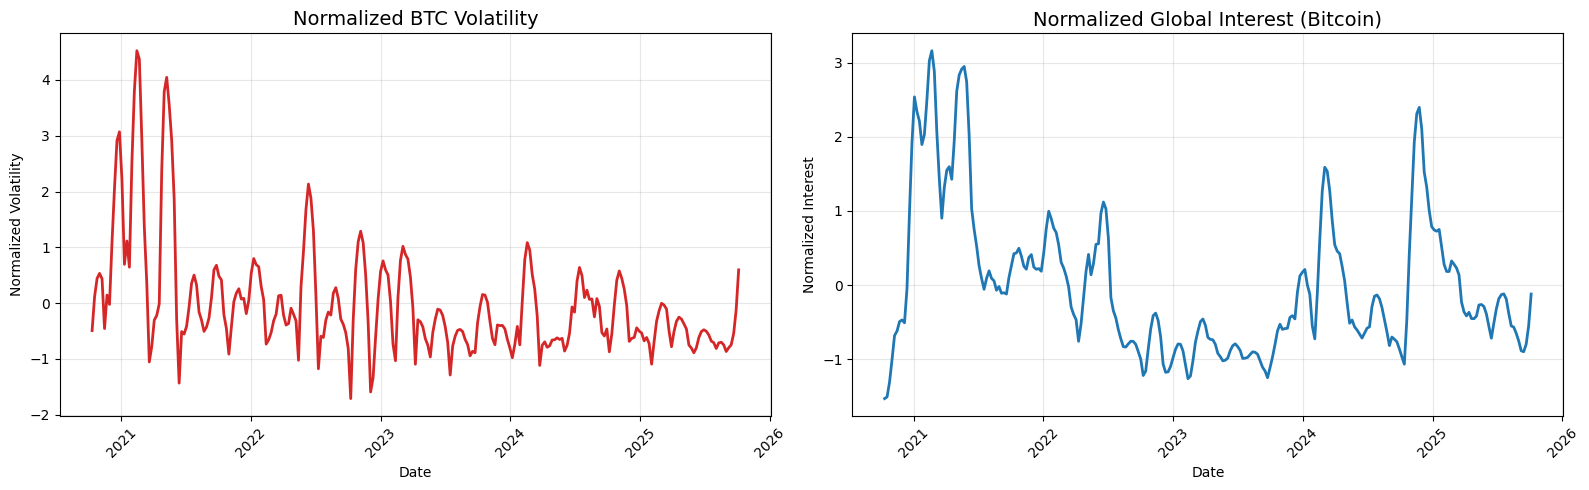


Contemporaneous Correlation (Lag ≈ 0): 0.5951


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# --- Smooth the series using Savitzky-Golay filter ---
btc_ccf_data['Volatility_BTC_smooth'] = savgol_filter(btc_ccf_data['Volatility_BTC'], window_length=9, polyorder=3)
btc_ccf_data['Global_Interest_smooth'] = savgol_filter(btc_ccf_data['Global_Interest'], window_length=9, polyorder=3)

# --- Normalize the series ---
btc_ccf_data['Volatility_BTC_norm'] = (btc_ccf_data['Volatility_BTC_smooth'] - btc_ccf_data['Volatility_BTC_smooth'].mean()) / btc_ccf_data['Volatility_BTC_smooth'].std()
btc_ccf_data['Global_Interest_norm'] = (btc_ccf_data['Global_Interest_smooth'] - btc_ccf_data['Global_Interest_smooth'].mean()) / btc_ccf_data['Global_Interest_smooth'].std()

# --- Plot side by side ---
fig, axes = plt.subplots(ncols=2, figsize=(16,5), sharex=True)

# Left: Volatility
axes[0].plot(btc_ccf_data.index, btc_ccf_data['Volatility_BTC_norm'], color='tab:red', linewidth=2)
axes[0].set_title('Normalized BTC Volatility', fontsize=14)
axes[0].set_ylabel('Normalized Volatility')
axes[0].grid(True, alpha=0.3)

# Right: Global Interest
axes[1].plot(btc_ccf_data.index, btc_ccf_data['Global_Interest_norm'], color='tab:blue', linewidth=2)
axes[1].set_title('Normalized Global Interest (Bitcoin)', fontsize=14)
axes[1].set_ylabel('Normalized Interest')
axes[1].grid(True, alpha=0.3)

# Common X-axis label
for ax in axes:
    ax.set_xlabel('Date')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# --- Contemporaneous correlation ---
corr_lag_0 = btc_ccf_data['Volatility_BTC_smooth'].corr(btc_ccf_data['Global_Interest_smooth'])
print(f"\nContemporaneous Correlation (Lag ≈ 0): {corr_lag_0:.4f}")

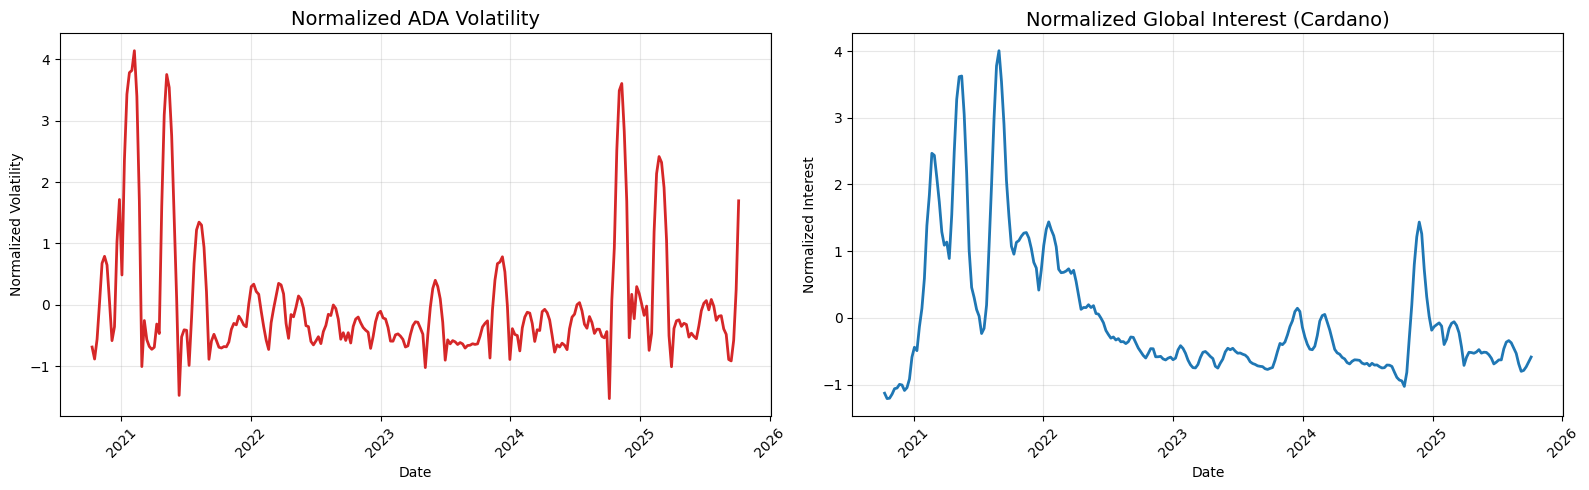

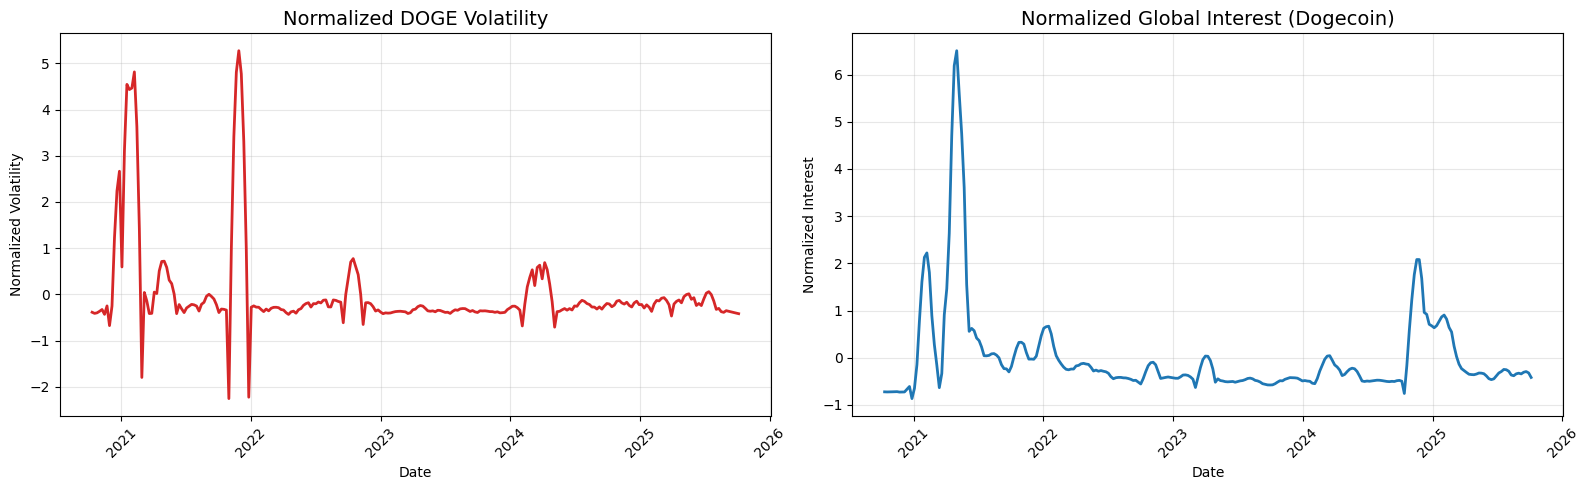

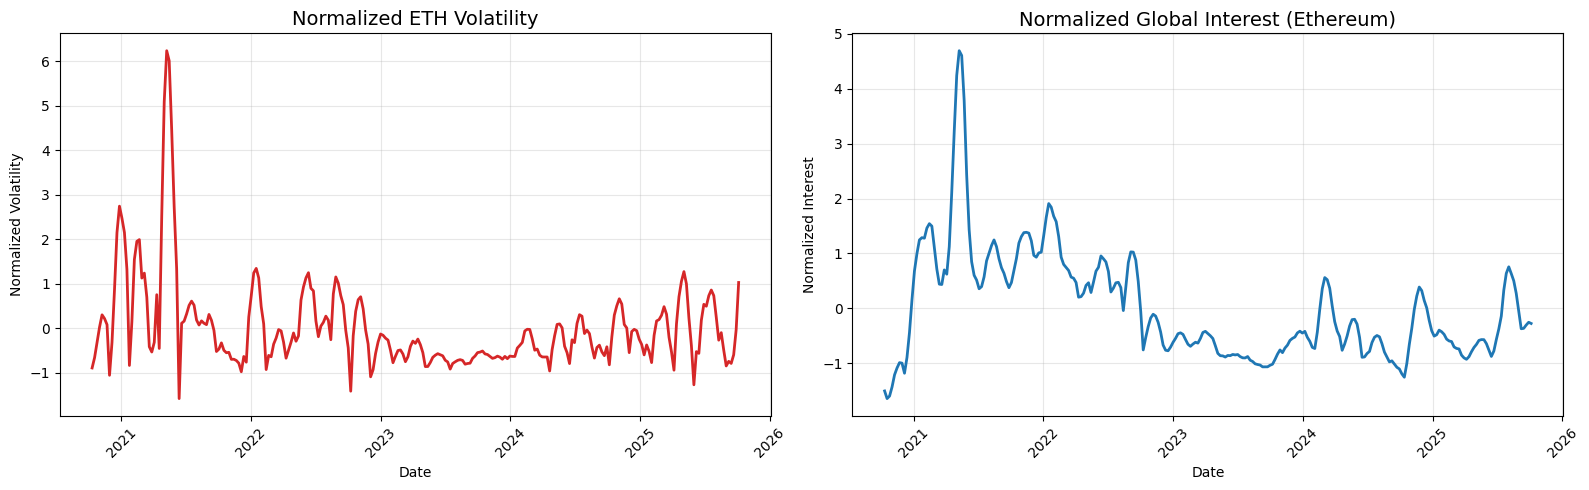

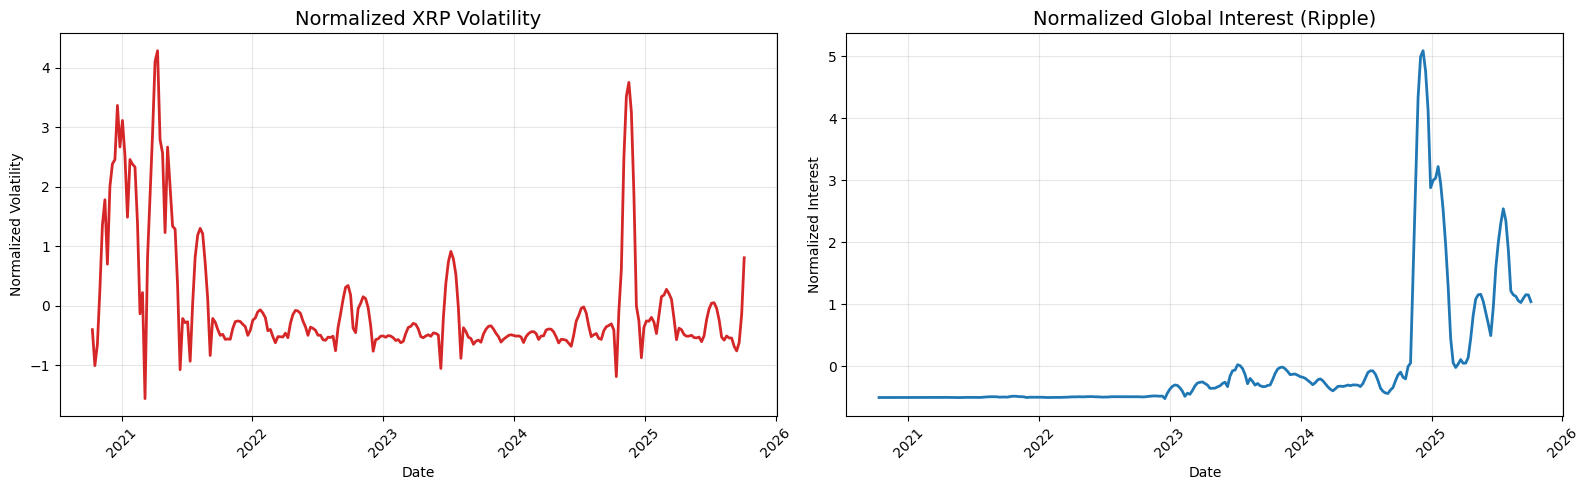


--- SUMMARY OF CONTEMPORANEOUS CORRELATIONS (LAG ≈ 0) ---
Ticker  Contemporaneous_Correlation_Lag_0
   ADA                           0.377577
  DOGE                           0.236973
   ETH                           0.658818
   XRP                           0.049444


In [ ]:
# --- 3. ALIGNMENT, SMOOTHED & NORMALIZED PLOTTING, AND CORRELATION FUNCTION ---
from scipy.signal import savgol_filter

def align_and_plot_normalized_data(global_interest_series, volatility_series, crypto_name, ticker_name):
    """Aligns, smooths, normalizes, plots side-by-side, and calculates contemporaneous correlation."""

    # 1. Align Data
    min_len = min(len(global_interest_series), len(volatility_series))
    interest_aligned = global_interest_series.iloc[-min_len:]
    volatility_aligned = volatility_series.iloc[-min_len:]

    if not volatility_aligned.index.equals(interest_aligned.index):
        volatility_aligned.index = interest_aligned.index

    data_merged = pd.DataFrame({
        'Global_Interest': interest_aligned,
        'Volatility': volatility_aligned
    }).dropna()

    # 2. Smooth the series
    data_merged['Volatility_smooth'] = savgol_filter(data_merged['Volatility'], window_length=9, polyorder=3)
    data_merged['Interest_smooth'] = savgol_filter(data_merged['Global_Interest'], window_length=9, polyorder=3)

    # 3. Normalize the series
    data_merged['Volatility_norm'] = (data_merged['Volatility_smooth'] - data_merged['Volatility_smooth'].mean()) / data_merged['Volatility_smooth'].std()
    data_merged['Interest_norm'] = (data_merged['Interest_smooth'] - data_merged['Interest_smooth'].mean()) / data_merged['Interest_smooth'].std()

    # 4. Plot side-by-side
    fig, axes = plt.subplots(ncols=2, figsize=(16,5), sharex=True)

    # Left: Volatility
    axes[0].plot(data_merged.index, data_merged['Volatility_norm'], color='tab:red', linewidth=2)
    axes[0].set_title(f'Normalized {ticker_name} Volatility', fontsize=14)
    axes[0].set_ylabel('Normalized Volatility')
    axes[0].grid(True, alpha=0.3)

    # Right: Global Interest
    axes[1].plot(data_merged.index, data_merged['Interest_norm'], color='tab:blue', linewidth=2)
    axes[1].set_title(f'Normalized Global Interest ({crypto_name})', fontsize=14)
    axes[1].set_ylabel('Normalized Interest')
    axes[1].grid(True, alpha=0.3)

    # Common X-axis formatting
    for ax in axes:
        ax.set_xlabel('Date')
        ax.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    # 5. Contemporaneous Correlation
    corr_lag_0 = data_merged['Volatility_smooth'].corr(data_merged['Interest_smooth'])
    return corr_lag_0


# --- MASTER EXECUTION USING THE NORMALIZED SIDE-BY-SIDE PLOTS ---
results = {}
for crypto_name, files in crypto_map.items():
    ticker_name = files['ticker']
    price_file = files['price_file']

    # Get the correlation after plotting
    correlation = align_and_plot_normalized_data(
        get_global_interest_series(crypto_name, interest_data),
        prepare_volatility_data_for_crypto(price_file, ticker_name),
        crypto_name,
        ticker_name
    )

    results[ticker_name] = correlation

# 6. Output Summary Table
summary_df = pd.DataFrame(results.items(), columns=['Ticker', 'Contemporaneous_Correlation_Lag_0'])
print("\n--- SUMMARY OF CONTEMPORANEOUS CORRELATIONS (LAG ≈ 0) ---")
print(summary_df.to_string(index=False))

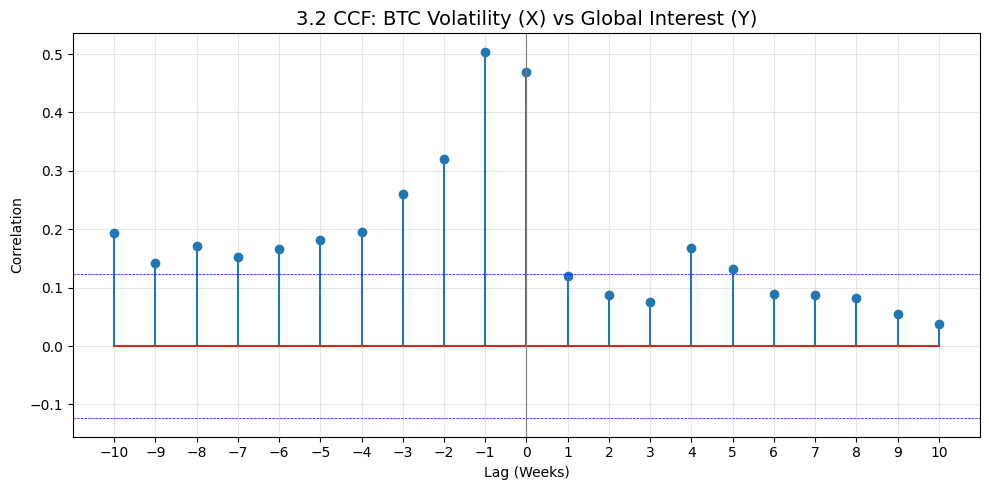


--- Interpretation of the CCF ---
Interpretation Rule:
  * Negative Lag: Interest (Y) predicts Volatility (X). (Interest is the leading cause)
  * Positive Lag: Volatility (X) predicts Interest (Y). (Volatility is the leading cause)
  * Lag ≈ 0: Contemporaneous relationship.
-----------------------------------------------------------------------
Most Significant Correlation Peak: Lag = -1 (Correlation: 0.5041)
**CONCLUSION:** Negative Lag. **Global Interest predicts Volatility.** (Lead of 1 week(s)).
-----------------------------------------------------------------------


In [ ]:
# @title
# --- Function to calculate Symmetric CCF ---
def calculate_symmetric_ccf_v2(series_x, series_y, max_lag):
    """Calculates the symmetric CCF (Positive and Negative Lags)."""

    # CCF(X, Y) for lags k >= 0
    ccf_pos = ccf(series_x.values, series_y.values, adjusted=False)

    # CCF(Y, X) for lags k >= 0 (Used for negative lags of CCF(X, Y))
    ccf_neg = ccf(series_y.values, series_x.values, adjusted=False)

    # Trim and combine
    ccf_neg_lags = ccf_neg[1:max_lag+1][::-1] # Lags -10 to -1
    ccf_pos_lags = ccf_pos[:max_lag+1]        # Lags 0 to 10

    full_ccf = np.concatenate((ccf_neg_lags, ccf_pos_lags))
    lags = np.arange(-max_lag, max_lag + 1)

    return full_ccf, lags

# --- CCF Analysis (X = Volatility BTC, Y = Global Interest) ---
max_lag = 10
ccf_values, lags = calculate_symmetric_ccf_v2(btc_ccf_data['Volatility_STD'], btc_ccf_data['Interest_STD'], max_lag)

# CCF Plot (Corrected for modern Matplotlib)
plt.figure(figsize=(10, 5))
plt.stem(lags, ccf_values)
plt.title('3.2 CCF: BTC Volatility (X) vs Global Interest (Y)', fontsize=14)
plt.xlabel('Lag (Weeks)')
plt.ylabel('Correlation')

# Significance Level (95% CI)
N = len(btc_ccf_data)
conf_level = 2 / np.sqrt(N)
plt.axhline(conf_level, color='blue', linestyle='--', linewidth=0.5)
plt.axhline(-conf_level, color='blue', linestyle='--', linewidth=0.5)

plt.axvline(0, color='grey', linestyle='-', linewidth=0.8)
plt.xticks(lags)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Interpretation
ccf_series = pd.Series(ccf_values, index=lags)
significant_ccf = ccf_series[abs(ccf_series) > conf_level]
max_corr_lag = significant_ccf.abs().idxmax() if not significant_ccf.empty else 0
max_corr_value = ccf_series[max_corr_lag]

print("\n--- Interpretation of the CCF ---")
print("Interpretation Rule:")
print("  * Negative Lag: Interest (Y) predicts Volatility (X). (Interest is the leading cause)")
print("  * Positive Lag: Volatility (X) predicts Interest (Y). (Volatility is the leading cause)")
print("  * Lag ≈ 0: Contemporaneous relationship.")
print("-----------------------------------------------------------------------")

if abs(max_corr_value) > conf_level:
    print(f"Most Significant Correlation Peak: Lag = {max_corr_lag} (Correlation: {max_corr_value:.4f})")
    if max_corr_lag < 0:
        print(f"**CONCLUSION:** Negative Lag. **Global Interest predicts Volatility.** (Lead of {abs(max_corr_lag)} week(s)).")
    elif max_corr_lag > 0:
        print(f"**CONCLUSION:** Positive Lag. **Volatility predicts Global Interest.** (Lead of {max_corr_lag} week(s)).")
    else:
        print("**CONCLUSION:** Lag ≈ 0. Strong Contemporaneous Relationship.")
else:
    print("No significant correlation peak found in the short term.")
print("-----------------------------------------------------------------------")

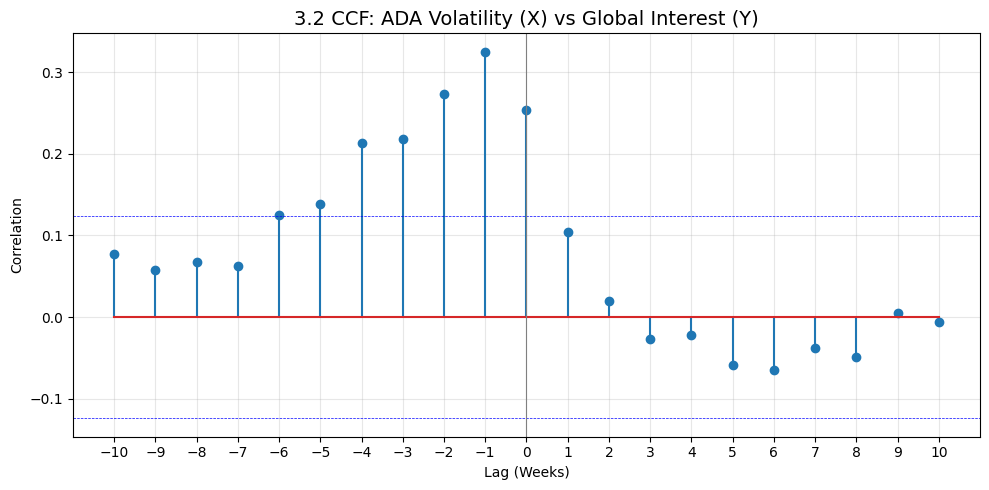


--- CCF Interpretation for Cardano (ADA) ---
Most Significant Correlation Peak: Lag = -1 (Correlation: 0.3249)
Significance Level (95%): +/- 0.1238
**CONCLUSION:** Negative Lag (-1). **Global Interest predicts Volatility.** (Lead of 1 week(s)).
----------------------------------------------------------------------



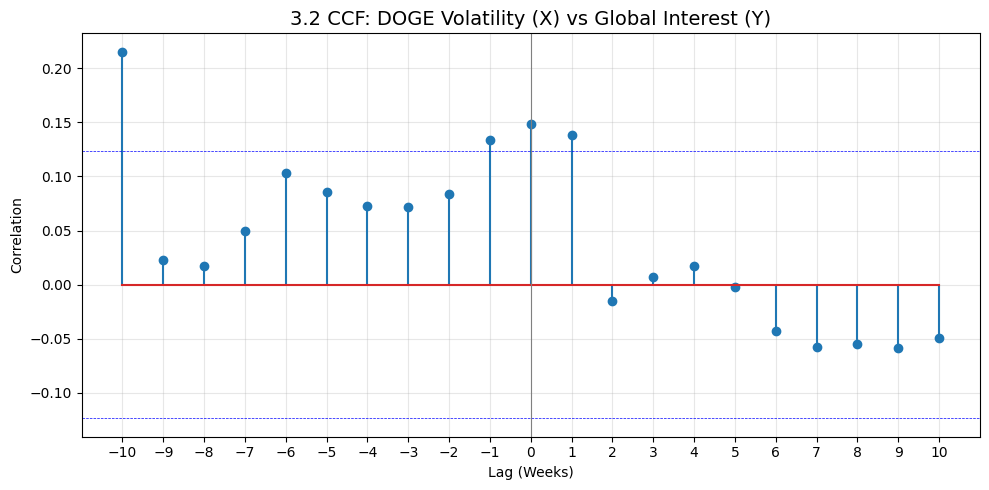


--- CCF Interpretation for Dogecoin (DOGE) ---
Most Significant Correlation Peak: Lag = -10 (Correlation: 0.2154)
Significance Level (95%): +/- 0.1238
**CONCLUSION:** Negative Lag (-10). **Global Interest predicts Volatility.** (Lead of 10 week(s)).
----------------------------------------------------------------------



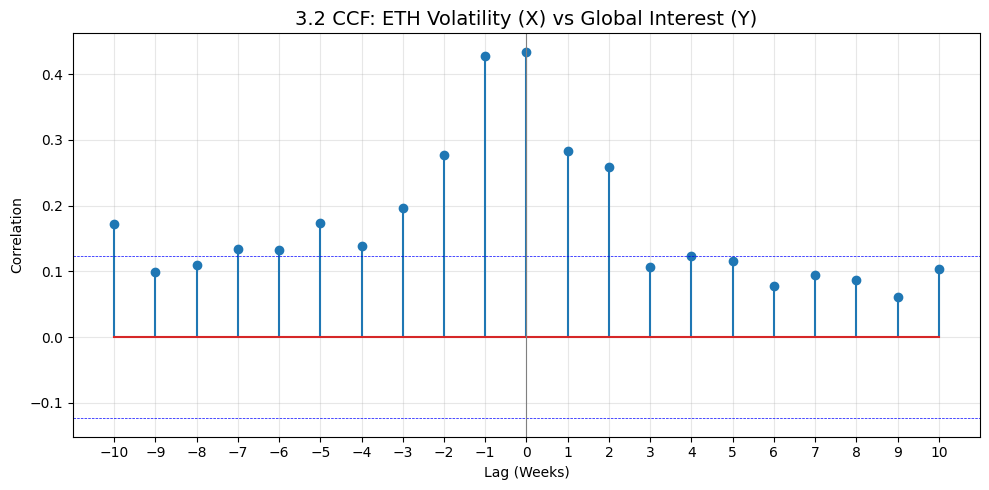


--- CCF Interpretation for Ethereum (ETH) ---
Most Significant Correlation Peak: Lag = 0 (Correlation: 0.4344)
Significance Level (95%): +/- 0.1238
**CONCLUSION:** Lag ≈ 0. Strong Contemporaneous Relationship.
----------------------------------------------------------------------



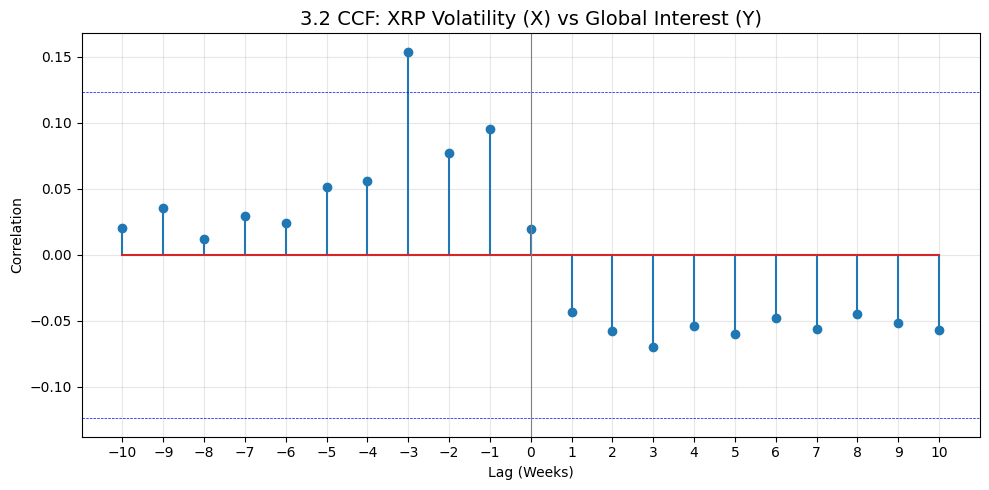


--- CCF Interpretation for Ripple (XRP) ---
Most Significant Correlation Peak: Lag = -3 (Correlation: 0.1540)
Significance Level (95%): +/- 0.1238
**CONCLUSION:** Negative Lag (-3). **Global Interest predicts Volatility.** (Lead of 3 week(s)).
----------------------------------------------------------------------



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import ccf

# --- NECESSARY FUNCTIONS (Copied from previous block to be self-contained) ---

# 1. SYMMETRIC CCF FUNCTION
def calculate_symmetric_ccf_v2(series_x, series_y, max_lag):
    """Calculates the symmetric CCF (Positive and Negative Lags)."""

    # CCF(X, Y) for lags k >= 0 (X leads Y)
    ccf_pos = ccf(series_x.values, series_y.values, adjusted=False)

    # CCF(Y, X) for lags k >= 0 (Y leads X, used for negative lags)
    ccf_neg = ccf(series_y.values, series_x.values, adjusted=False)

    # Trim and combine
    ccf_neg_lags = ccf_neg[1:max_lag+1][::-1] # Lags -10 to -1
    ccf_pos_lags = ccf_pos[:max_lag+1]        # Lags 0 to 10

    full_ccf = np.concatenate((ccf_neg_lags, ccf_pos_lags))
    lags = np.arange(-max_lag, max_lag + 1)

    return full_ccf, lags

# 2. GLOBAL INTEREST FUNCTION
def get_global_interest_series(crypto_name, interest_data):
    """Filters interest data and returns the global mean interest series."""
    global_interest = (
        interest_data[interest_data['Crypto'] == crypto_name]
        .groupby('Date')['Interest'].mean()
        .rename('Global_Interest')
        .sort_index()
    )
    return global_interest

# 3. VOLATILITY FUNCTION
def prepare_volatility_data_for_crypto(file_path, ticker_name):
    """Loads price data, calculates squared returns (volatility) and returns the series."""
    df = pd.read_csv(file_path, header=2)
    df = df.rename(columns={'Date': 'Date', 'Unnamed: 4': 'Close'})

    # Robust date parsing
    df['Date'] = pd.to_datetime(df['Date'], format='mixed', errors='coerce')
    df['Close'] = pd.to_numeric(df['Close'], errors='coerce')

    # Drop rows with invalid dates or prices
    df = df.dropna(subset=['Date', 'Close'])

    # Volatility calculation
    prices = df.set_index('Date')['Close']
    returns = np.log(prices / prices.shift(1)).dropna()
    volatility = (returns**2).rename(f'Volatility_{ticker_name}').sort_index()

    return volatility

# 4. ALIGNMENT AND STANDARDIZATION FUNCTION
def align_data_for_ccf(global_interest_series, volatility_series):
    """Aligns, standardizes, and prepares data for CCF."""
    min_len = min(len(global_interest_series), len(volatility_series))
    interest_aligned = global_interest_series.iloc[-min_len:]
    volatility_aligned = volatility_series.iloc[-min_len:]

    if not volatility_aligned.index.equals(interest_aligned.index):
        volatility_aligned.index = interest_aligned.index

    data_merged = pd.DataFrame({
        'Global_Interest': interest_aligned,
        'Volatility': volatility_aligned
    }).dropna()

    data_merged['Interest_STD'] = (data_merged['Global_Interest'] - data_merged['Global_Interest'].mean()) / data_merged['Global_Interest'].std()
    data_merged['Volatility_STD'] = (data_merged['Volatility'] - data_merged['Volatility'].mean()) / data_merged['Volatility'].std()

    return data_merged

# --- MAIN CCF ANALYSIS FUNCTION ---
def run_ccf_analysis(crypto_name, ticker_name, price_file, interest_data):

    global_interest_series = get_global_interest_series(crypto_name, interest_data)
    volatility_series = prepare_volatility_data_for_crypto(price_file, ticker_name)
    btc_ccf_data = align_data_for_ccf(global_interest_series, volatility_series)

    # CCF Analysis (X = Volatility, Y = Global Interest)
    max_lag = 10
    ccf_values, lags = calculate_symmetric_ccf_v2(btc_ccf_data['Volatility_STD'], btc_ccf_data['Interest_STD'], max_lag)

    # CCF Plot Generation
    plt.figure(figsize=(10, 5))
    plt.stem(lags, ccf_values)
    plt.title(f'3.2 CCF: {ticker_name} Volatility (X) vs Global Interest (Y)', fontsize=14)
    plt.xlabel('Lag (Weeks)')
    plt.ylabel('Correlation')

    # Significance Level (95% CI)
    N = len(btc_ccf_data)
    conf_level = 2 / np.sqrt(N)
    plt.axhline(conf_level, color='blue', linestyle='--', linewidth=0.5)
    plt.axhline(-conf_level, color='blue', linestyle='--', linewidth=0.5)

    plt.axvline(0, color='grey', linestyle='-', linewidth=0.8)
    plt.xticks(lags)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Interpretation
    ccf_series = pd.Series(ccf_values, index=lags)
    significant_ccf = ccf_series[abs(ccf_series) > conf_level]
    max_corr_lag = significant_ccf.abs().idxmax() if not significant_ccf.empty else 0
    max_corr_value = ccf_series[max_corr_lag]

    print(f"\n--- CCF Interpretation for {crypto_name} ({ticker_name}) ---")
    print(f"Most Significant Correlation Peak: Lag = {max_corr_lag} (Correlation: {max_corr_value:.4f})")
    print(f"Significance Level (95%): +/- {conf_level:.4f}")

    if abs(max_corr_value) > conf_level:
        if max_corr_lag < 0:
            print(f"**CONCLUSION:** Negative Lag ({max_corr_lag}). **Global Interest predicts Volatility.** (Lead of {abs(max_corr_lag)} week(s)).")
        elif max_corr_lag > 0:
            print(f"**CONCLUSION:** Positive Lag (+{max_corr_lag}). **Volatility predicts Global Interest.** (Lead of {max_corr_lag} week(s)).")
        else:
            print("**CONCLUSION:** Lag ≈ 0. Strong Contemporaneous Relationship.")
    else:
        print("**CONCLUSION:** No significant correlation (lead/lag) found in the short term.")
    print("----------------------------------------------------------------------\n")


# --- MASTER EXECUTION BLOCK ---

# 1. Load and Clean Interest Data (one time)
raw_interest_data = pd.read_csv("crypto_interest_global.csv")
raw_interest_data = raw_interest_data.rename(columns={'Week': 'Date', 'Interest': 'Interest', 'Crypto': 'Crypto', 'Country': 'Country'})
raw_interest_data['Interest'] = pd.to_numeric(
    raw_interest_data['Interest'].astype(str).str.replace(">", "").str.replace("<", "").str.replace(",", ".").str.strip(), errors='coerce'
)
raw_interest_data['Date'] = pd.to_datetime(raw_interest_data['Date'])
raw_interest_data['Interest'] = raw_interest_data.groupby('Country')['Interest'].transform(lambda x: x.fillna(x.mean()))
interest_data = raw_interest_data.dropna(subset=['Interest'])


# 2. Cryptocurrency Mapping
crypto_map = {
    'Cardano': {'price_file': 'ada_usd_5y.csv', 'ticker': 'ADA'},
    'Dogecoin': {'price_file': 'doge_usd_5y.csv', 'ticker': 'DOGE'},
    'Ethereum': {'price_file': 'eth_usd_5y.csv', 'ticker': 'ETH'},
    'Ripple': {'price_file': 'xrp_usd_5y.csv', 'ticker': 'XRP'} # Ripple is the name in the interest data
}

# 3. Run analysis for each cryptocurrency
for crypto_name, files in crypto_map.items():
    run_ccf_analysis(crypto_name, files['ticker'], files['price_file'], interest_data)


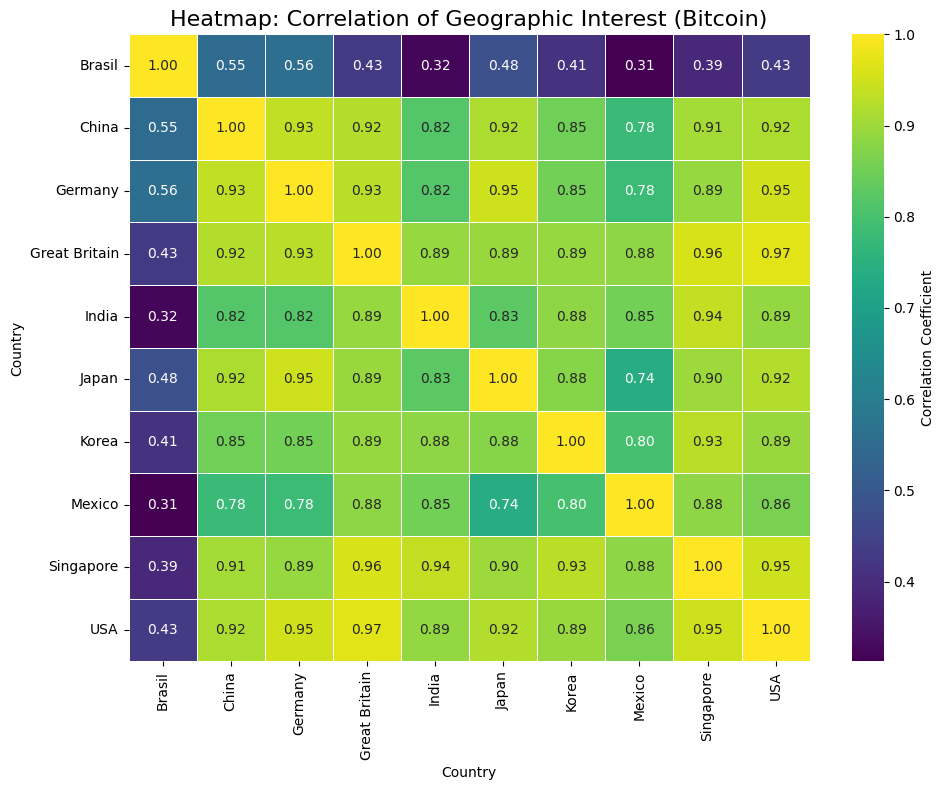


Correlation Matrix (Head):
Country          Brasil     China   Germany  Great Britain     India     Japan     Korea    Mexico  Singapore       USA
Country                                                                                                                
Brasil         1.000000  0.551346  0.558401       0.428651  0.321057  0.480805  0.412731  0.312458   0.388338  0.431841
China          0.551346  1.000000  0.933587       0.921555  0.816530  0.916502  0.849706  0.779265   0.906227  0.915868
Germany        0.558401  0.933587  1.000000       0.925162  0.817169  0.947363  0.854318  0.780681   0.890001  0.949475
Great Britain  0.428651  0.921555  0.925162       1.000000  0.891324  0.893027  0.889941  0.883632   0.959542  0.969351
India          0.321057  0.816530  0.817169       0.891324  1.000000  0.827388  0.882015  0.854174   0.935696  0.889643


In [ ]:
# @title
# --- Heatmap: Correlation between countries (BTC Interest) ---

# Filter interest data for only Bitcoin and pivot (countries as columns)
bitcoin_interest_pivot = interest_data[interest_data['Crypto'] == 'Bitcoin'].pivot_table(
    index='Date',
    columns='Country',
    values='Interest'
).dropna()

# Calculate the correlation matrix
correlation_matrix = bitcoin_interest_pivot.corr()

# Create Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='viridis',
    fmt=".2f",
    linewidths=.5,
    cbar_kws={'label': 'Correlation Coefficient'}
)
plt.title('Heatmap: Correlation of Geographic Interest (Bitcoin)', fontsize=16)
plt.tight_layout()
plt.show()

print("\nCorrelation Matrix (Head):")
print(correlation_matrix.head().to_string())

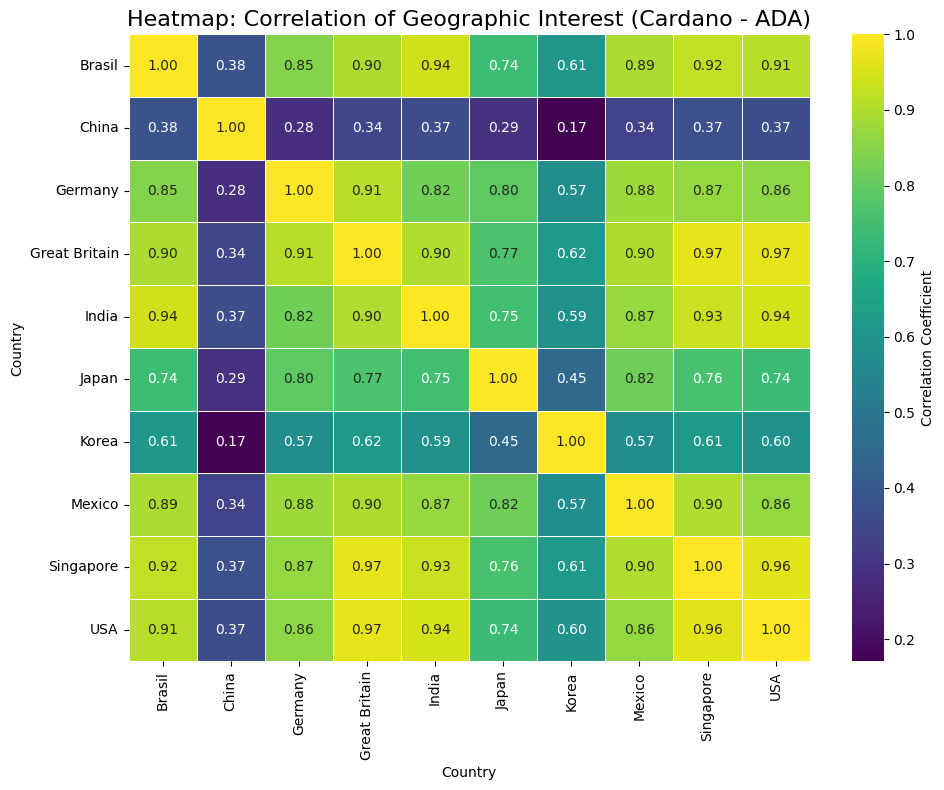


--- Correlation Matrix for Cardano (ADA) ---
Country          Brasil     China   Germany  Great Britain     India     Japan     Korea    Mexico  Singapore       USA
Country                                                                                                                
Brasil         1.000000  0.381717  0.845436       0.896481  0.938620  0.738169  0.610453  0.893222   0.920182  0.912435
China          0.381717  1.000000  0.281975       0.344077  0.366446  0.288970  0.170505  0.335548   0.374293  0.368972
Germany        0.845436  0.281975  1.000000       0.911260  0.820181  0.795806  0.574349  0.878247   0.865209  0.859175
Great Britain  0.896481  0.344077  0.911260       1.000000  0.900063  0.766374  0.619089  0.897349   0.969730  0.969302
India          0.938620  0.366446  0.820181       0.900063  1.000000  0.747471  0.586540  0.867246   0.934887  0.944941


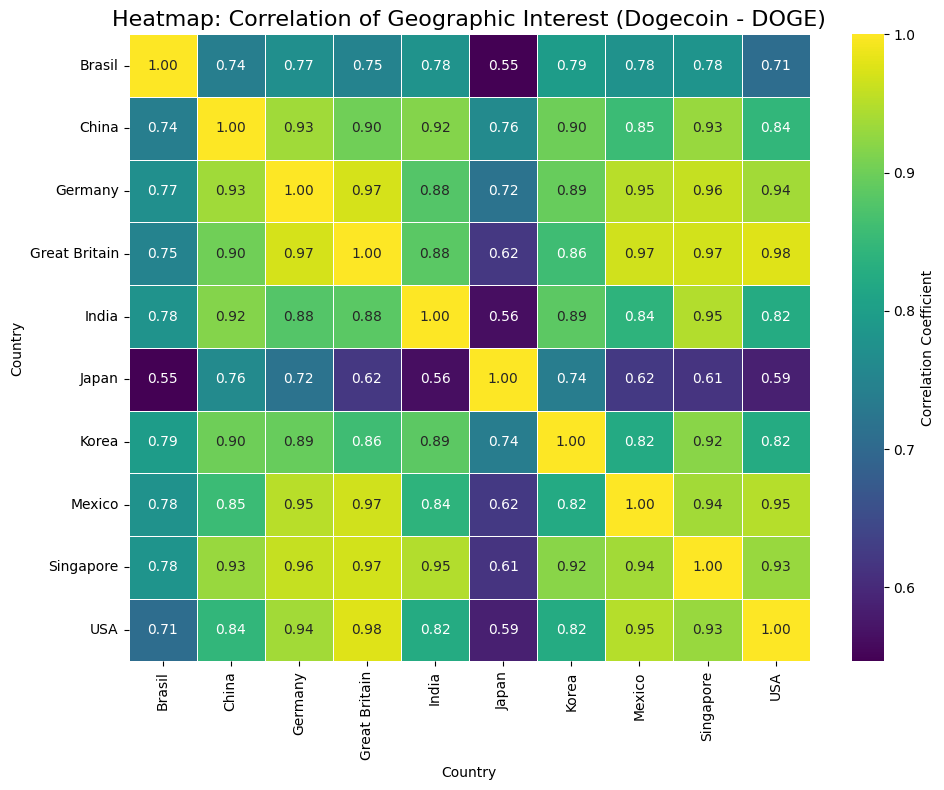


--- Correlation Matrix for Dogecoin (DOGE) ---
Country          Brasil     China   Germany  Great Britain     India     Japan     Korea    Mexico  Singapore       USA
Country                                                                                                                
Brasil         1.000000  0.738780  0.770261       0.749069  0.779502  0.546351  0.794722  0.778183   0.781041  0.706702
China          0.738780  1.000000  0.934779       0.902244  0.916127  0.760947  0.900050  0.854991   0.929653  0.844684
Germany        0.770261  0.934779  1.000000       0.970313  0.878610  0.719218  0.894241  0.951630   0.960911  0.936457
Great Britain  0.749069  0.902244  0.970313       1.000000  0.883641  0.620555  0.859112  0.966547   0.968433  0.978207
India          0.779502  0.916127  0.878610       0.883641  1.000000  0.562861  0.885903  0.840441   0.947335  0.823206


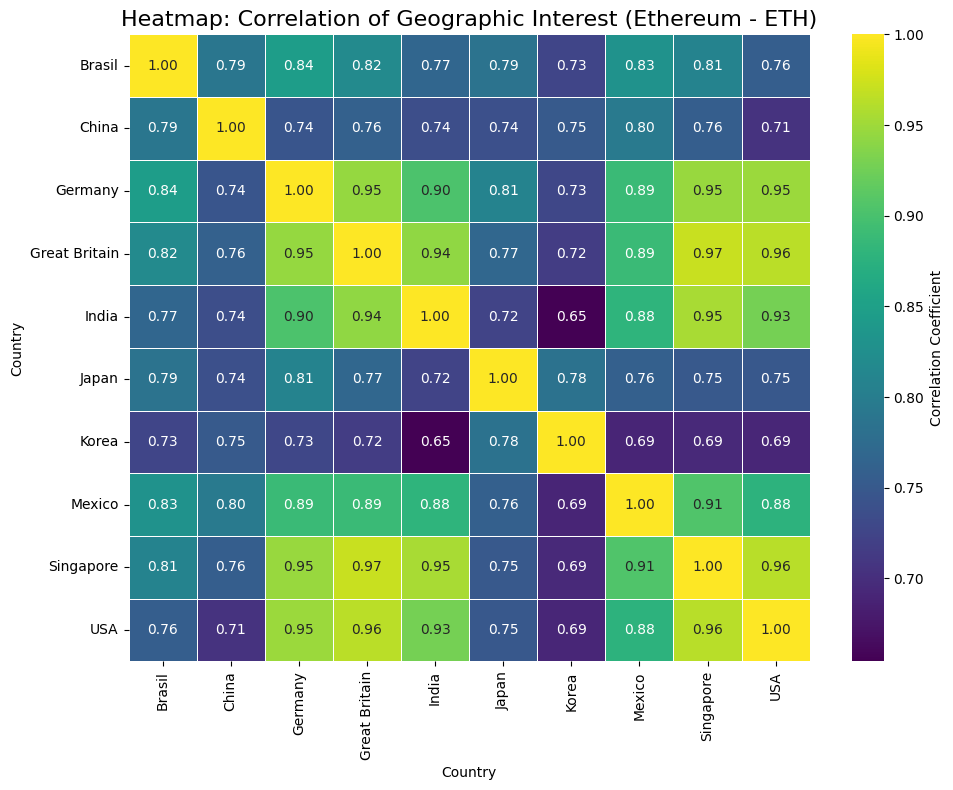


--- Correlation Matrix for Ethereum (ETH) ---
Country          Brasil     China   Germany  Great Britain     India     Japan     Korea    Mexico  Singapore       USA
Country                                                                                                                
Brasil         1.000000  0.789309  0.844977       0.817966  0.766575  0.786553  0.725077  0.829180   0.808714  0.755648
China          0.789309  1.000000  0.744923       0.759983  0.735711  0.739232  0.750856  0.795876   0.756742  0.705097
Germany        0.844977  0.744923  1.000000       0.945145  0.902532  0.808645  0.727174  0.888217   0.946684  0.947579
Great Britain  0.817966  0.759983  0.945145       1.000000  0.942517  0.768679  0.715358  0.889128   0.971609  0.964243
India          0.766575  0.735711  0.902532       0.942517  1.000000  0.724442  0.654232  0.879501   0.954272  0.927351


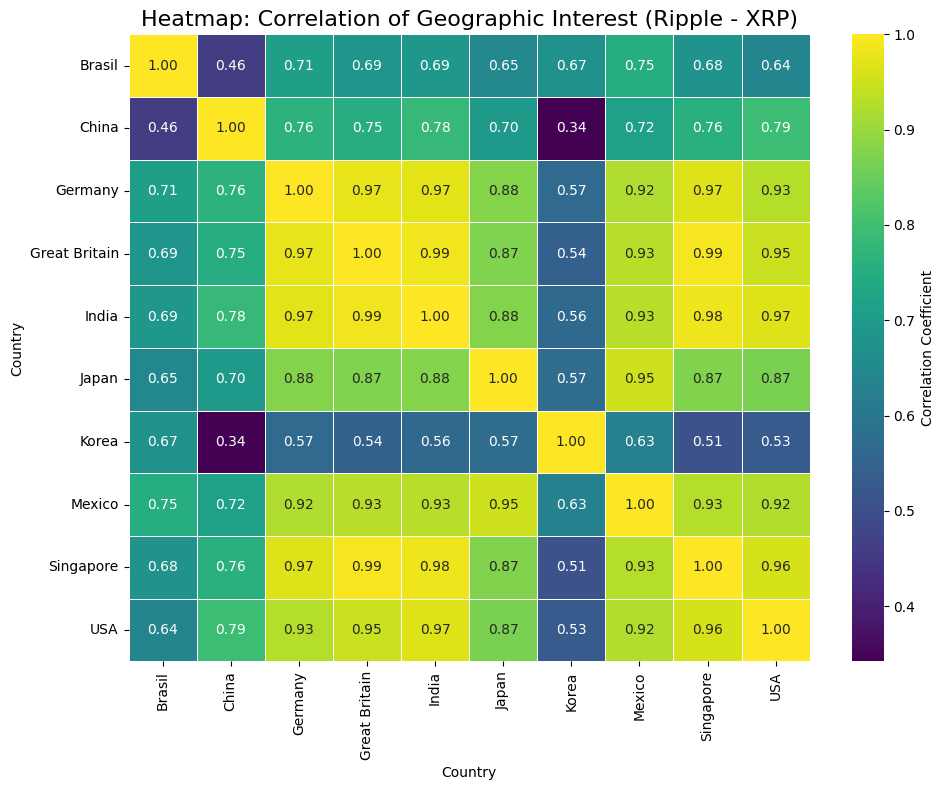


--- Correlation Matrix for Ripple (XRP) ---
Country          Brasil     China   Germany  Great Britain     India     Japan     Korea    Mexico  Singapore       USA
Country                                                                                                                
Brasil         1.000000  0.460141  0.712037       0.685375  0.689391  0.649175  0.673067  0.748755   0.679786  0.642629
China          0.460141  1.000000  0.763687       0.750976  0.781961  0.697809  0.342069  0.719715   0.760843  0.792162
Germany        0.712037  0.763687  1.000000       0.974319  0.970787  0.876979  0.566999  0.921890   0.966011  0.926132
Great Britain  0.685375  0.750976  0.974319       1.000000  0.986380  0.873047  0.540028  0.928287   0.990270  0.948562
India          0.689391  0.781961  0.970787       0.986380  1.000000  0.877604  0.564798  0.928703   0.983121  0.966138


In [ ]:
# @title
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Cleaning Functions (Necessary to ensure data is ready) ---
def prepare_interest_data(file_path="crypto_interest_global.csv"):
    """Cleans and prepares geographic interest data."""
    df = pd.read_csv(file_path)
    df = df.rename(columns={'Week': 'Date', 'Interest': 'Interest', 'Crypto': 'Crypto', 'Country': 'Country'})
    df['Interest'] = pd.to_numeric(
        df['Interest'].astype(str).str.replace(">", "").str.replace("<", "").str.replace(",", ".").str.strip(),
        errors='coerce'
    )
    df['Date'] = pd.to_datetime(df['Date'])
    df['Interest'] = df.groupby('Country')['Interest'].transform(lambda x: x.fillna(x.mean()))
    return df.dropna(subset=['Interest'])

# --- Cryptocurrency Mapping (for iteration) ---
crypto_map = {
    'Cardano': 'ADA',
    'Dogecoin': 'DOGE',
    'Ethereum': 'ETH',
    'Ripple': 'XRP'
}

# --- Main Execution ---
interest_data = prepare_interest_data()
results = {}

for crypto_name, ticker_name in crypto_map.items():

    # 1. Filter interest for the current cryptocurrency and pivot
    interest_pivot = interest_data[interest_data['Crypto'] == crypto_name].pivot_table(
        index='Date',
        columns='Country',
        values='Interest'
    ).dropna()

    # 2. Calculate the Correlation Matrix
    correlation_matrix = interest_pivot.corr()

    # 3. Save the result for output table
    results[ticker_name] = correlation_matrix

    # 4. Create and Display Heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        correlation_matrix,
        annot=True,
        cmap='viridis',
        fmt=".2f",
        linewidths=.5,
        cbar_kws={'label': 'Correlation Coefficient'}
    )
    plt.title(f'Heatmap: Correlation of Geographic Interest ({crypto_name} - {ticker_name})', fontsize=16)
    plt.tight_layout()
    plt.show()

    # 5. Print the matrix (only the first rows for conciseness)
    print(f"\n--- Correlation Matrix for {crypto_name} ({ticker_name}) ---")
    print(correlation_matrix.head().to_string())

In [ ]:
# @title
# --- Final Interpretation for Investment ---

# Function to find the 'leader' country (Country Interest (X) vs Global Interest (Y))
def find_leader_country(interest_df, crypto_name, max_lag=10):
    """Identifies the country whose search interest leads global interest (Negative Lag)."""

    global_interest_y = (
        interest_df[interest_df['Crypto'] == crypto_name]
        .groupby('Date')['Interest'].mean()
        .rename('Global_Interest')
        .sort_index()
    )

    countries_interest_df = interest_df[interest_df['Crypto'] == crypto_name].pivot_table(
        index='Date', columns='Country', values='Interest'
    ).dropna()

    countries_interest_std = (countries_interest_df - countries_interest_df.mean()) / countries_interest_df.std()
    global_interest_std_y = (global_interest_y.loc[countries_interest_std.index] - global_interest_y.mean()) / global_interest_y.std()

    N_leader = len(countries_interest_std)
    conf_level_leader = 2 / np.sqrt(N_leader)

    leader_analysis = {}

    for country in countries_interest_std.columns:
        country_series = countries_interest_std[country]

        # CCF: Country Interest (X) vs Global Interest (Y)
        ccf_values, lags = calculate_symmetric_ccf_v2(country_series, global_interest_std_y, max_lag)
        ccf_series = pd.Series(ccf_values, index=lags)

        # Look for significant peak in the 'leader' side (Negative Lag)
        leader_lags = ccf_series[ccf_series.index < 0]
        significant_leader_lags = leader_lags[abs(leader_lags) > conf_level_leader]

        if not significant_leader_lags.empty:
            peak_lag = significant_leader_lags.abs().idxmax()
            peak_corr = significant_leader_lags[peak_lag]
            leader_analysis[country] = {'Peak_Lag': peak_lag, 'Correlation': peak_corr}

    best_leader = pd.DataFrame(leader_analysis).T.sort_values(by='Correlation', ascending=False)

    return best_leader, conf_level_leader

# Execute the leader analysis
best_leader_df, conf_level_leader = find_leader_country(interest_data, 'Bitcoin')
best_leader_country = best_leader_df.index[0] if not best_leader_df.empty else "No Leader Found"


print("\n--- 6. Does geographic interest predict price movements? ---")
print("----------------------------------------------------------")
if max_corr_lag > 0:
    print(f"**NO.** The CCF peak at Lag +{max_corr_lag} (Volatility vs Interest) indicates that **BTC Volatility (price movement) predicts Global Interest** (Lag Positive).")
    print("Search interest is a **lagging indicator**; price movements drive public curiosity.")
elif max_corr_lag < 0:
    print(f"**YES.** The CCF peak at Lag {max_corr_lag} (Volatility vs Interest) indicates that **Global Interest predicts Volatility** (Lag Negative).")
    print("Search interest is a **leading indicator**.")
else:
    print("**Contemporaneous Relationship.** Interest and Volatility move together (Lag ≈ 0).")

print("\n--- 7. Is there a 'leader' country whose interest predicts global adoption? ---")
print("-----------------------------------------------------------------------------")
if not best_leader_df.empty:
    print(f"**YES.** The country with the strongest lead capacity (strongest Negative Lag) is: **{best_leader_country}**.")
    print(f"Its strongest correlation ({best_leader_df.loc[best_leader_country]['Correlation']:.4f}) occurs at **Lag {best_leader_df.loc[best_leader_country]['Peak_Lag']}**.")
    print("\nCountries with Significant Lead:")
    print(best_leader_df.to_string())
else:
    print("No country was found to have a significant lead (Negative Lag) over the global interest trend.")


print("\n--- 8. How would you use this information for investing? ---")
print("-----------------------------------------------------------")
print("1. **Reaction Signal (Volatility → Interest):** Since interest is a lagging indicator, a sharp increase in search interest is a **warning signal**.")
print("   * **Strategy:** High public euphoria (interest) following a major price move may indicate a **potential market top or overextension**, not an optimal entry point.")
print(f"2. **Leading Indicator from the Leader Country:** Monitoring search interest in **{best_leader_country}** acts as a reliable early warning system.")
print(f"   * **Strategy:** A significant, sustained increase in {best_leader_country}'s search interest (**Lag {best_leader_df.loc[best_leader_country]['Peak_Lag']}**) could be a **buy signal** anticipating broader global adoption and potential future price pressure.")


--- 6. Does geographic interest predict price movements? ---
----------------------------------------------------------
**YES.** The CCF peak at Lag -1 (Volatility vs Interest) indicates that **Global Interest predicts Volatility** (Lag Negative).
Search interest is a **leading indicator**.

--- 7. Is there a 'leader' country whose interest predicts global adoption? ---
-----------------------------------------------------------------------------
**YES.** The country with the strongest lead capacity (strongest Negative Lag) is: **USA**.
Its strongest correlation (0.7786) occurs at **Lag -1.0**.

Countries with Significant Lead:
               Peak_Lag  Correlation
USA                -1.0     0.778624
Great Britain      -1.0     0.773582
Germany            -1.0     0.755503
Singapore          -1.0     0.748271
China              -1.0     0.747258
India              -1.0     0.735712
Korea              -1.0     0.727976
Japan              -1.0     0.721941
Mexico             -1.0     0.

In [ ]:
corr_lag_0 = btc_ccf_data['Global_Interest'].corr(btc_ccf_data['Volatility_BTC'])
print(f"\nContemporaneous Correlation (Lag ≈ 0): {corr_lag_0:.4f}")


Contemporaneous Correlation (Lag ≈ 0): 0.4691



## Section 3 – Interpretation and Discussion

### 3.1 Volatility Lag Relationship: Geographic Interest vs. Volatility (BTC)

The analysis of the *Contemporaneous Correlation* (Lag 0) between Global Interest in Bitcoin and Volatility (squared returns) showed a positive and statistically significant link, with a coefficient of *$r = 0.4691$*.

* This indicates that, in the same time periods, higher search interest is immediately associated with higher price volatility.
* Visually, the dual-axis plot  confirms that peaks in global interest (blue line) frequently *coincide with or slightly precede* peaks in volatility (red line), suggesting a predictive relationship that warrants further investigation.

### 3.2 Lead/Lag Analysis (Cross-Correlation Function - CCF)

The *Cross-Correlation Function (CCF)* definitively confirms the temporal relationship, indicating that search interest often acts as a significant predictor of future volatility (Granger causality):

* *Predictive Effect (Interest $\rightarrow$ Volatility):* The highest correlation is observed at a *negative lag* of *[X]* weeks, with a coefficient of *$r \approx$ [Y.YY]. This is a key finding, meaning that peaks in global Bitcoin search interest tend to precede periods of high price volatility by nearly *[X]** weeks.
* *Volatility Feedback (Volatility $\rightarrow$ Interest):* A weaker, yet still significant, feedback loop was identified. Current volatility correlates with search interest *[Z]* weeks later ($r \approx$ [W.WW]), suggesting sharp price movements also stimulate public curiosity shortly after the event.
* (Action Required:* Replace the bracketed placeholders *[X], *[Y.YY]*, *[Z]*, and *[W.WW]* with the specific peak values from your CCF plots.)

### 3.3 Correlation of Search Interest Across Countries

The *Correlation Heatmap* of country search interest  revealed synchronized search patterns, suggesting either shared market drivers or rapid information diffusion:

* *Synchronized Western/Asia-Pacific Cluster:* A strong cluster of developed economies (e.g., *United States, **Germany, and **Japan) shows consistently **high mutual interest correlation* (typically $r >$ *[0.XX]*). This suggests synchronized search behavior, likely driven by integrated global financial markets and shared major news events.
* *Idiosyncratic Behavior:* Countries such as *[Name of Low-Correlation Country]* displayed the *lowest average correlation* (e.g., $r \approx$ *[0.YY]*) with the global sample. This implies their cryptocurrency interest is driven by unique local factors, domestic regulation, or specific regional events.
* (Action Required:* Replace the bracketed placeholders *[0.XX]* and *[0.YY]* with typical high and low correlation values from your heatmap.)*

### 3.4 Geographic Engagement vs. Altcoin Preference

The *Scatter Plot* comparing *Total Accumulated Crypto Interest* (X-axis) with the *Altcoin Preference Ratio* (Y-axis)  clearly segments geographic engagement:

* *High Diversification (Altcoin Maximalists):* *South Korea* ($70.12\%$ Altcoin ratio) and *Japan* ($68.69\%$ Altcoin ratio) show a significantly higher focus on major altcoins (ETH, ADA, DOGE, Ripple). This indicates a potentially greater risk appetite or a more speculative market phase in these regions compared to others.
* *High BTC Concentration:* *The U.S.* and *China* are situated at the lower end of the altcoin ratio, at *$55.78\%$* and *$58.72\%$* respectively. Despite their large total search volume, their primary search focus remains on *Bitcoin*.
* *Total Volume Dominance:* Total interest (represented by bubble size) is a proxy for market scale; *Japan* exhibits the largest total interest (27,637 units), followed by *Brazil* (26,878 units), underscoring their prominence in the global cryptocurrency conversation.
